In [4]:
import sys

In [5]:
BASE_DIR = "../.."
DATA_DIR = f"{BASE_DIR}/data"
NBDATA_DIR = f"{BASE_DIR}/nbdata"
FIG_DIR = f"{BASE_DIR}/figs"

In [6]:
sys.path.append(BASE_DIR)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import anndata as ad
import scanpy as sc

## Read Data

### Transcriptomic

In [9]:
rna_adata = ad.read_csv(f"{DATA_DIR}/iPSC_DESeq_JUL2015_all_merged_ensemble_DataLevel3.csv").T

In [10]:
rna_meta = pd.read_csv(f"{DATA_DIR}/RNAseq_metadata.tsv",sep="\t")
rna_meta["Condition"] = rna_meta.IP_Name.transform(lambda x: x.split("-")[0][-3:])
rna_adata.obs = rna_meta

In [11]:
rna_adata.obs[['ip_center_batch_id','Condition']].to_csv(f'{NBDATA_DIR}/iPSC_id_condition_map.tsv',sep='\t',header=True,index=False)

In [12]:
rna_adata

AnnData object with n_obs × n_vars = 29 × 63677
    obs: 'IP_Name', 'IP_LINCS_ID', 'ip_center_batch_id', 'IP_Known_Mutations', 'IP_Mutation_Citations', 'IP_Culture_Conditions', 'IP_Passaging_Method', 'IP_Passage_Number', 'IP_Passage_Last_Karyotyping', 'IP_Recommended_Culture_Conditions', 'IP_Relevant_Citations', 'IP_Center_Name', 'IP_Provider_Name', 'IP_Provider_Catalog_ID', 'IP_Provider_Batch_ID', 'IP_Center_Specific_Code', 'IP_Quality_Verification', 'IP_Alternative_Name', 'IP_Alternative_ID', 'IP_Molecular_Features', 'IP_Related_Projects', 'IP_Cell_Markers', 'IP_Transient_Modification', 'IP_Genetic_Modification', 'Condition'

## Gene Name Mapping

In [9]:
import biomart                                                                                                                                                                                              

def get_ensembl_mappings():    
    # from https://gist.github.com/ben-heil/cffbebf8865795fe2efbbfec041da969
    # Set up connection to server                                                                                                                                                                           
    server = biomart.BiomartServer('http://useast.ensembl.org/biomart')                                                                                                                                     
    mart = server.datasets['hsapiens_gene_ensembl']                                                                                                                                                        

    # List the types of data we want                                                                                                                                                                        
    attributes = ['ensembl_transcript_id', 'hgnc_symbol',                                                                                                                                                    
                  'ensembl_gene_id', 'ensembl_peptide_id']                                                                                                                                                  

    # Get the mapping between the attributes                                                                                                                                                                
    response = mart.search({'attributes': attributes})                                                                                                                                                      
    data = response.raw.data.decode('ascii')                                                                                                                                                                

    ensembl_to_genesymbol = {}                                                                                                                                                                              
    # Store the data in a dict                                                                                                                                                                              
    for line in data.splitlines():                                                                                                                                                                          
        line = line.split('\t')                                                                                                                                                                             
        # The entries are in the same order as in the `attributes` variable                                                                                                                                 
        transcript_id = line[0]                                                                                                                                                                             
        gene_symbol = line[1]                                                                                                                                                                               
        ensembl_gene = line[2]                                                                                                                                                                              
        ensembl_peptide = line[3]                                                                                                                                                                           

        # Some of these keys may be an empty string. If you want, you can
        # avoid having a '' key in your dict by ensuring the
        # transcript/gene/peptide ids have a nonzero length before
        # adding them to the dict
        ensembl_to_genesymbol[transcript_id] = gene_symbol
        ensembl_to_genesymbol[ensembl_gene] = gene_symbol
        ensembl_to_genesymbol[ensembl_peptide] = gene_symbol

    return ensembl_to_genesymbol

ens2gene = get_ensembl_mappings()

In [10]:
from gprofiler import GProfiler
from tqdm.notebook import tqdm

def get_ens2hgnc_mappings(query_list):

    gp = GProfiler(return_dataframe=True)
    gp_database = gp.convert(organism='hsapiens',query=query_list, target_namespace='HGNC').set_index('incoming')
    
    ens2hgnc = {}
    for ens in tqdm(query_list):
        mapper = gp_database.loc[ens,'converted']
        if not isinstance(mapper,str):
            mapper = mapper[0]
        if mapper == 'None':
            mapper = ens
        ens2hgnc[ens] = mapper
    
        
    return ens2hgnc

ens2gene = get_ens2hgnc_mappings(list(rna_adata.var.index))

  0%|          | 0/63677 [00:00<?, ?it/s]

In [11]:
rna_adata.var['HGNC'] = rna_adata.var.index.map(ens2gene)

In [17]:
rna_adata.var\
    .reset_index()[['index','HGNC']]\
    .rename({'index':'ENSG'},axis=1)\
    .sort_values(by='ENSG')\
    .to_csv(f'{NBDATA_DIR}/iPSC_ENSG_HGNC_mapping.tsv',sep='\t',header=True,index=False)

## Split by Condition

In [48]:
rna_adata_ctr = rna_adata[rna_adata.obs.Condition == 'CTR']
rna_adata_als = rna_adata[rna_adata.obs.Condition == 'ALS']
rna_adata_sma = rna_adata[rna_adata.obs.Condition == 'SMA']

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [82]:
rna_adata_als

AnnData object with n_obs × n_vars = 12 × 32718
    obs: 'IP_Name', 'IP_LINCS_ID', 'ip_center_batch_id', 'IP_Known_Mutations', 'IP_Mutation_Citations', 'IP_Culture_Conditions', 'IP_Passaging_Method', 'IP_Passage_Number', 'IP_Passage_Last_Karyotyping', 'IP_Recommended_Culture_Conditions', 'IP_Relevant_Citations', 'IP_Center_Name', 'IP_Provider_Name', 'IP_Provider_Catalog_ID', 'IP_Provider_Batch_ID', 'IP_Center_Specific_Code', 'IP_Quality_Verification', 'IP_Alternative_Name', 'IP_Alternative_ID', 'IP_Molecular_Features', 'IP_Related_Projects', 'IP_Cell_Markers', 'IP_Transient_Modification', 'IP_Genetic_Modification', 'Condition', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'HGNC', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersio

## RNA Preprocessing and QC

In [49]:
def preprocess_and_qc(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    adata.var['mt'] = adata.var.HGNC.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)
    
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    
    return adata

In [50]:
rna_adata_ctr = preprocess_and_qc(rna_adata_ctr)
rna_adata_als = preprocess_and_qc(rna_adata_als)

Trying to set attribute `.obs` of view, copying.
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:
Trying to set attribute `.obs` of view, copying.
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


### Highly Variable Genes

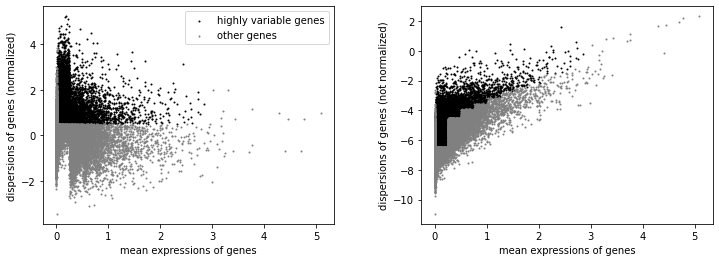

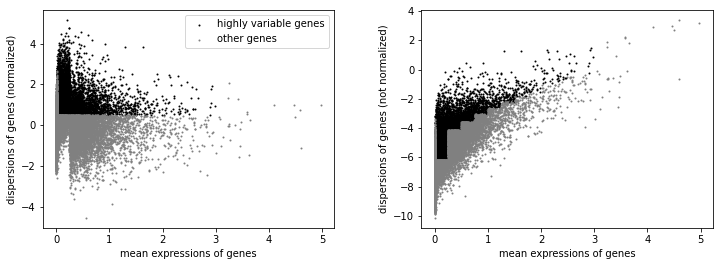

In [51]:
sc.pl.highly_variable_genes(rna_adata_als)
sc.pl.highly_variable_genes(rna_adata_ctr)

In [52]:
rna_adata_ctr.var[rna_adata_ctr.var.highly_variable].sort_values(by='total_counts',ascending=False).head()

,HGNC,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
ENSG00000152661,GJA1,8,False,8,2.938997,1.370926,0.0,23.511972,3.199162,True,2.986594,0.862180,0.927068
ENSG00000140988,RPS2,8,False,8,2.879912,1.355812,0.0,23.039293,3.179690,True,2.896774,-0.217506,0.516767
ENSG00000231500,RPS18,8,False,8,2.870066,1.353271,0.0,22.960526,3.176408,True,2.892879,0.251492,0.894089
ENSG00000080824,HSP90AA1,8,False,8,2.866907,1.352455,0.0,22.935255,3.175353,True,2.906403,0.471016,1.070703
ENSG00000265992,ESRG,8,False,8,2.846929,1.347275,0.0,22.775433,3.168653,True,2.939378,1.494964,1.894499


In [53]:
rna_adata_als.var[rna_adata_als.var.highly_variable].sort_values(by='total_counts',ascending=False).head()

,HGNC,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
ENSG00000044574,HSPA5,12,False,12,2.824671,1.341472,0.0,33.896049,3.552374,True,2.845477,-0.214520,1.396384
ENSG00000179218,CALR,12,False,12,2.750354,1.321850,0.0,33.004250,3.526485,True,2.766760,-0.571884,0.918428
ENSG00000155380,SLC16A1,12,False,12,2.703302,1.309225,0.0,32.439629,3.509742,True,2.720874,-0.474562,1.003539
ENSG00000104332,SFRP1,12,False,12,2.699947,1.308318,0.0,32.399364,3.508537,True,2.732139,0.192775,1.587142
ENSG00000140545,MFGE8,12,False,12,2.678055,1.302384,0.0,32.136662,3.500640,True,2.723558,0.563596,1.911434


### Fold Change in Case/Control Mean Counts

In [150]:
fold_change = rna_adata_als.var[['HGNC','mean_counts']].set_index('HGNC') / rna_adata_ctr.var[['HGNC','mean_counts']].set_index('HGNC')

In [151]:
fold_change.sort_values(by='mean_counts',ascending=False)

,mean_counts
HGNC,
PEG3,189.554962
GYG2P1,25.309408
POTEC,20.834879
CXADRP3,13.292338
ZNF257,11.761340
...,...
ZNF90P3,NaN
ZNF98,NaN
ZNRF4,NaN


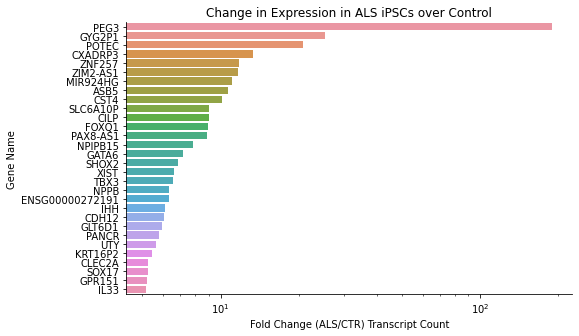

In [170]:
plt.figure(figsize=(8, 5))
sns.barplot(data=fold_change.reset_index().sort_values(by='mean_counts',ascending=False).head(30),y='HGNC',x='mean_counts')
sns.despine()
plt.ylabel('Gene Name')
plt.xlabel('Fold Change (ALS/CTR) Transcript Count')
# plt.xscale('log',base=2)
plt.xscale('log')
plt.title('Change in Expression in ALS iPSCs over Control')
plt.savefig(f"{FIG_DIR}/als_ctr_fold_change_rna.png",bbox_inches='tight')

### Highly Expressed (- mitochondrial)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


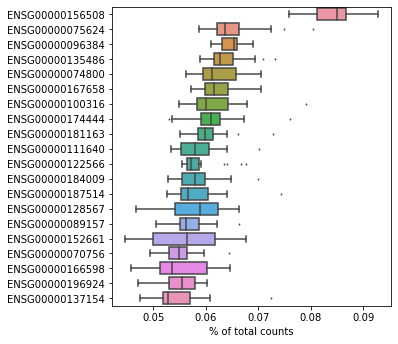

In [44]:
sc.pl.highest_expr_genes(rna_adata[:,~rna_adata.var.mt], n_top=20, )

In [45]:
rna_adata[:,~rna_adata.var.mt].var.sort_values(by='total_counts',ascending=False)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,HGNC,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
ENSG00000156508,EEF1A1,29,False,29,4.422039,1.690472,0.000000,128.239120,4.861664,False,4.440307,1.081052,-0.707107
ENSG00000075624,ACTB,29,False,29,3.423992,1.487042,0.000000,99.295761,4.608123,False,3.446537,0.474388,0.169538
ENSG00000096384,HSP90AB1,29,False,29,3.400498,1.481718,0.000000,98.614456,4.601307,False,3.406837,-0.909180,-1.198873
ENSG00000135486,HNRNPA1,29,False,29,3.342783,1.468516,0.000000,96.940720,4.584363,False,3.351440,-0.624069,-0.916885
ENSG00000074800,ENO1,29,False,29,3.269775,1.451561,0.000000,94.823463,4.562508,False,3.296112,0.504974,0.199789
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000231983,LINC00415,3,False,3,0.000036,0.000036,89.655172,0.001034,0.001033,False,0.000036,-8.045547,-0.991768
ENSG00000211780,TRAV6,3,False,3,0.000035,0.000035,89.655172,0.001027,0.001026,False,0.000035,-8.052823,-0.997443
ENSG00000260487,,3,False,3,0.000035,0.000035,89.655172,0.001027,0.001026,False,0.000035,-8.052955,-0.997546
ENSG00000254472,OR4A49P,3,False,3,0.000035,0.000035,89.655172,0.001027,0.001026,False,0.000035,-8.052955,-0.997546


## Write H5

In [63]:
control_save_path = f"{BASE_DIR}/nbdata/iPSC_rna_ctr_preprocessed.h5ad"
als_save_path = f"{BASE_DIR}/nbdata/iPSC_rna_als_preprocessed.h5ad"

In [64]:
rna_adata_als.write(als_save_path)
rna_adata_ctr.write(control_save_path)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


# Write Transcription Factors as txt

In [58]:
tf_list = pd.read_csv('../data/HumanTFs.csv',index_col=1)

In [61]:
common_tfs = set(rna_adata.var.index).intersection(set(tf_list.index))

In [62]:
with open('../nbdata/human_tflist.txt','w+') as f:
    for tf in list(common_tfs):
        f.write(f"{tf}\n")